## Kleinberg's HITS algorithm

The HITS algorithm begins with the observation that there are two kinds of
important pages on the World Wide Web, the kind that
are link **targets** for a lot of important 
pages, and the kind that are link **sources** for a lot of important pages.  The first
kind of important page is called an **authority**.  The second kind of important
page is called a **hub**.

The `networkx` module includes an implementation of Kleinberg's HITS
algorithm.  What the algorithm does is to assign two scores to each node in a network, a hub score and an
authority score. So two score dictionaries are returned called `h` and `a` in the code below.

h {0: -0.1639431704860946, 1: 0.6523112533185894, 2: -0.36837696025103006, 3: 0.813418828163659, 4: -0.29541538542637996, 5: 0.36200543468125634}
a {0: 0.36200543468125634, 1: -0.29541538542637996, 2: 0.813418828163659, 3: -0.36837696025103017, 4: 0.6523112533185894, 5: -0.1639431704860946}


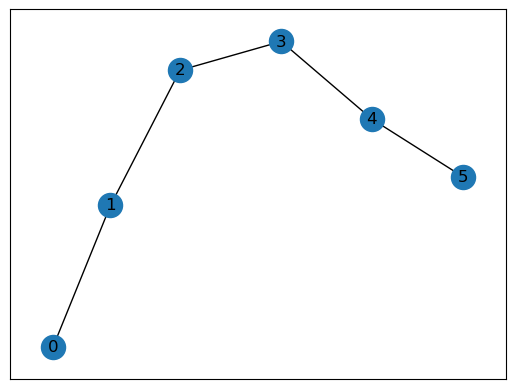

In [47]:

import networkx as nx
import matplotlib.pyplot as plt

G0=nx.path_graph(6)
#G0=nx.path_graph(5)
h,a=nx.hits(G0,max_iter=100)
print ('h', h)
print ('a', a)


# Draw graph with some customization, Fruhcterman-Reingold layout
pos = nx.drawing.fruchterman_reingold_layout(G0)
nx.draw_networkx_nodes(G0,pos)
## dd is label dict: Label nodes with their numerical ids.
dd = dict(zip(G0.nodes(),G0.nodes()))
nx.draw_networkx_labels(G0,pos, dd)
nx.draw_networkx_edges(G0,pos)
plt.show()
 


Notice that in this particular example there is a very simple relation between the hub scores and the authority scores. 

$$
h(i) = a(N-1-i)
$$

where $N=5$, the number of nodes.

This is because the path graph we passed in was an undirected graph.  Since the hub/authority distinction makes no sense for an undirected graph, the first thing `nx.hits` does is to change the graph into a directed graph by replacing each undirected edge with two directed edges.  If there was an undirected edge between two nodes $n_1$ and $n_2$, it was replaced with a directed edge fron $n_1$ to $n_2$ and another from $n_2$ to $n_1$.  In this way the hub and authority properties of each node exactly balanced, and each node ended up with its hub score equal to its authority score. 

In terms of what the numbers actually **mean**, that's a longer story, but notice that the hub scores add up to 1, as do the authority scores.  So you can think of a node's authority score as representing the proportion of the total *authority  mass* in the network that that node owns, and similarly for its hub score.

Note also that those scores are different for different nodes.  In part that's due to how connected they are; node 1 is connected to two nodes, 0 and 2, so it has better scores than  node 0, which is connected to only one node.  But it's more subtle than that.  Note that node 2 has better scores than node 1, even though both are connected to two nodes.  That's because node 2's connections are more important than node 1's connections. Node 2 is connected to those well-connected nodes, 1 and 3, while node 1 is connected to one well-connected node, node 2,
and one loser, node 0.  So the score a node gets depends on the hub/authority status of its neighbors, which in turn depend on the hub authority properties of their neighbors, and so on.

HITS is actually a bit more specific about what makes good hubs and good authorities.  The following assumptions
lead directly to the equations used to compute the HITS scores:

 1. Good authorities are pointed to by good hubs.
 2. Good hubs point to good authorities.

Let's try again and this time let's be sure to make a graph where the incoming and outgoing edges do different things,
which is what the algorithm is intended to handle.


### Checking the equations

h [0.43425855 0.         0.18858048 0.18858048 0.18858048]
a [0.         0.43425855 0.18858048 0.18858048 0.18858048]


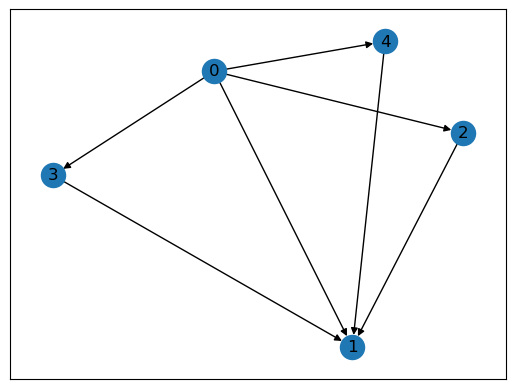

In [81]:
import networkx as nx
import matplotlib.pyplot as plt

G0=nx.DiGraph()
# Make node 0 a hub
for a in range (1, 5):
    G0.add_edge(0,a)
# Make node 1 an authority
for a in range(5):
    if a != 1:
       G0.add_edge(a,1)
h,a=nx.hits(G0)
h_arr = np.array([h[i] for i in range(len(G0))])
a_arr = np.array([a[i] for i in range(len(G0))])
print ('h', h_arr)
print ('a', a_arr)
# Draw!
pos = nx.drawing.fruchterman_reingold_layout(G0)
dd = dict(zip(G0.nodes(),G0.nodes()))
nx.draw_networkx_nodes(G0,pos, dd)
nx.draw_networkx_labels(G0,pos, dd)
nx.draw_networkx_edges(G0,pos)
plt.show()
 

Clearly, vertex 1 is a much better hub than any other vertex. And clearly 0 is a much better
authority.  And the `h` and `a` scores reflect this.

Note also that vertex 0 has a low authority score (0), because no node points to it.  Conversely, node 1 has a 
low hub score (0), because it points to nothing.  Meanwhile, nodes 2, 3, and 4 have identical scores because their hub/authority situations are identical: Each points to the same great authority (node 1) and is pointed to by the same great hub (node 0).

Let's check whether the implementation respects equations in (7.24) p.180 of Newman.

In [90]:
import numpy as np
A0 = nx.to_numpy_array(G0)

# Hub scores come from the leading eigenvector of the cocitation network
(cocit_vals,cocit_vecs) = np.linalg.eig(A0@(A0.T))
## Authority scores come from the leading eigenvector of the bibliographic coupling network 
(bib_vals,bib_vecs) = np.linalg.eig((A0.T)@A0)

First eigenval is leader.

In [95]:
bib_vals

array([5.30277564e+00, 1.69722436e+00, 6.28687657e-18, 3.00888257e-16,
       0.00000000e+00])

So authority values come from the first column of `bib_vecs`

In [96]:
bib_arr = bib_vecs[:,0]
bib_arr

array([ 0.        , -0.79917148, -0.34704704, -0.34704704, -0.34704704])

We want to compare this with what `nx.hits` gave us as the authority centralities vector.

In [97]:
a_arr

array([0.        , 0.43425855, 0.18858048, 0.18858048, 0.18858048])

Showing that `bib_arr` is a rescaling of `a_arr`.

In [101]:
(bib_arr[1]/a_arr[1])* a_arr

array([-0.        , -0.79917148, -0.34704704, -0.34704704, -0.34704704])

Now let's check Eq. 7.26, p. 180, which provides the easy to compute `a_arr` once given `h_arr`.

In [52]:
h_arr = np.array([h[i] for i in range(len(G0))])
a_arr = A0.T@h_arr
# demonstrating the right relation between h and a vals (Eq. 7.26, p. 180)
print(h_arr)
print((a[0]/a_arr[0])*a_arr)



[-0.16394317  0.65231125 -0.36837696  0.81341883 -0.29541539  0.36200543]
[ 0.36200543 -0.29541539  0.81341883 -0.36837696  0.65231125 -0.16394317]


## Exercise

Here's a new graph and its hub and authority scores.  Answer some questions about how those scores turned out. A note for those not using to reading Python numbers in scientific notation.  Just think of the numbers with `e-09` in them as very small numbers, pretty much equal to 0.

h {1: 2.55291490847555e-18, 3: 0.6180339887498949, 2: 0.3819660112501052}
a {1: 0.6180339887498949, 3: 4.1307030922997666e-18, 2: 0.38196601125010515}


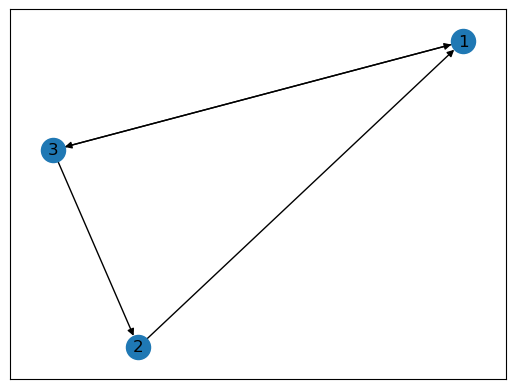

In [4]:
G0=nx.DiGraph()
# Make node 0 a hub,
G0.add_edge(1,3)
G0.add_edge(2,1)
G0.add_edge(3,1)
G0.add_edge(3,2)
h,a=nx.hits(G0)
print ('h', h)
print ('a', a)
# Draw!
pos = nx.drawing.fruchterman_reingold_layout(G0)
dd = dict(zip(G0.nodes(),G0.nodes()))
nx.draw_networkx_nodes(G0,pos, dd)
nx.draw_networkx_labels(G0,pos, dd)
nx.draw_networkx_edges(G0,pos)
plt.show()
 

### Questions

1)  Nodes  2 and 3 have indegree 1.  Why is node 3's authority score so small relative to node 2's 
    authority  score?
2)  Nodes 1 and 2 both have outdegree 1.  Why is node 1's hub score so small relative to node 2's hub score?